# SWOP script 5 - Linear Mixed Effects Analysis
## 100-300 ms time window

This script imports a CSV file generated by the script *SWOP 4 - Measure ERPS* and performs linear mixed effects modelling.

Following general best practices, we are using **individual trial** data. Note that outliers (defined as data points at the level of subjets/trials/channels with abs(*z*) > 2.5) have been removed in script 4. 

A few technical notes:
- while LME is most commonly run using the *lmer()* function in the *lme4* package, we instead use the *bam()* function in the *mgcv* package. While mgcv/bam is written for generalized additive modelling, it allows for LME by using the *bs='re'* flag for smooths (where  're' stands for 'random effects'). The *bam()* function is parallelized, as well as being well-optimized, making it much faster to run, and without convergence errors that sometimes plague *lmer()* models
- best practices  in LME modelling tend to encourage full random effects models, and also by-item random effects and even random slopes for items within subjects. However, these models quickly become computationally very expensive, both in terms of time and RAM required. They are computed  here, but it is impossible to generate the tables of results and effet sizes with *emmeans()*, nor plot the contrasts of interest. My past experience, as well as experience with this dataset, is that these more elaborate random effects models do generate much smaller AIC values, and higher explained variance of the models. However, they do not in any appreciable way impact the general pattern of results (in terms of what's significant in the ANOVA tables, nor the effect sizes of our contrasts of interest). For these reasons, the models we ultimately present are not the "best" in the sense of AIC values or explained variance, but they tell efefctively the same story. For reference, however, the more complex models are computed and summarized here for reference. 

---
Copyright 2016-21  [Aaron J Newman](https://github.com/aaronjnewman), [NeuroCognitive Imaging Lab](http://ncil.science), [Dalhousie University](https://dal.ca)

Released under the [BSD 3-clause license](https://opensource.org/licenses/BSD-3-Clause)

---

## Load necessary libraries

In [1]:
date()

[1] "Mon Sep 27 16:06:57 2021"

In [2]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(mgcv)
library(parallel)
# library(viridis)
library(emmeans)
library(sjPlot)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:dplyr':

    collapse


This is mgcv 1.8-36. For overview type 'help("mgcv-package")'.

Registered S3 methods overwritten by 'parameters':
  method                           from      
  as.double.parameters_kurtosis    datawizard
  as.double.parameters_skewness    datawizard
  as.double.parameters_smoothness  datawizard
  as.numeric.parameters_kurtosis   datawizard
  as.numeric.parameters_skewness   datawizard
  as.numeric.parameters_smoothness datawizard
  print.parameters_distribution    datawizard
  print.parameters_kurtosis        datawizard
  print.parameters_skewness        datawizard
  summary.parameters_kurtosis      datawizard
  summary.parameters_skewness      datawizard

L

## Set parameters for this analysis

In [3]:
component = '100-300'
expt = 'SWOP'
data_path = '../group_data/'
out_path = '../results/'

data_file = paste(data_path, 'SWOP_ERP_measurements.csv', sep="")

# num parallel processes for bam(). Should be less than the number of threads supported by your CPU
num_cores = 3

options("scipen"=100, "digits"=5)  # force decimal instead of scientific notation

## Load Data

In [4]:
dat <- read.csv(data_file,
               colClasses=c('factor', 'numeric', 'factor', 
                            'factor', 'factor', 'factor', 
                            'factor',  'factor', 'factor', 
                            'numeric', 'factor', 'factor',
                            'factor', 'factor', 'factor', 
                            'factor', 'numeric', 'factor',
                            'numeric'
                           )
               )

dat$ROI <- factor(dat$ROI, levels=c('L_Ant', 'M_Ant', 'R_Ant',
                                       'L_Cent', 'M_Cent', 'R_Cent',
                                       'L_Post', 'M_Post', 'R_Post'
                                      ))

# specify ordering of condtiions, for plots and contrats
dat$Adverb <- factor(dat$Adverb, levels=c('kanske', 'hemma', 'idag'))
# Force contrasts as V3-V2
dat$SentPos <- factor(dat$SentPos, levels=c('V3', 'V2'))

### Select only data for ERP component of interest

In [5]:
dat <- subset(dat, Component==component | Component=='baseline')
dat <- droplevels(dat)

### Remove missing data 

In [6]:
dat <- dat[complete.cases(dat), ]

## Summary/Descriptives

In [7]:
summary(dat)

    Subject        Trial.Time          Condition          ROI       
 s_04nm : 6394   Min.   :   1157   V2/hemma :21051   L_Post :18918  
 s_18ak : 6347   1st Qu.: 500439   V2/idag  :20832   L_Cent :18874  
 s_21ma : 6340   Median :1071213   V2/kanske:20944   R_Cent :18811  
 s_27lm : 6334   Mean   :1097288   V3/hemma :21122   R_Post :18782  
 s_26nm : 6328   3rd Qu.:1656271   V3/idag  :21050   R_Ant  :18709  
 s_13ff : 6325   Max.   :2977152   V3/kanske:21019   L_Ant  :18687  
 (Other):87950                                       (Other):13237  
    Channel         Sentence      postphrase  pronoun_noun questiondisplay.ACC
 P7     : 4791   277    :   540   0.0:21025   N:63004      0: 20200           
 TP8    : 4791   316    :   540   1.0:23112   P:63014      1:105818           
 TP7    : 4788   112    :   539   2.0:17336                                   
 T8     : 4784   152    :   539   3.0:25060                                   
 FT8    : 4775   206    :   539   4.0:22470          

In [8]:
str(dat)

'data.frame':	126018 obs. of  19 variables:
 $ Subject            : Factor w/ 20 levels "s_04nm","s_07ba",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Trial.Time         : num  34102 34102 34102 34102 34102 ...
 $ Condition          : Factor w/ 6 levels "V2/hemma","V2/idag",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ ROI                : Factor w/ 9 levels "L_Ant","M_Ant",..: 1 1 1 1 4 4 4 4 7 7 ...
 $ Channel            : Factor w/ 27 levels "C3","C4","CP3",..: 6 8 10 12 1 3 24 26 15 17 ...
 $ Sentence           : Factor w/ 240 levels "10","101","102",..: 215 215 215 215 215 215 215 215 215 215 ...
 $ postphrase         : Factor w/ 6 levels "0.0","1.0","2.0",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ pronoun_noun       : Factor w/ 2 levels "N","P": 1 1 1 1 1 1 1 1 1 1 ...
 $ questiondisplay.ACC: Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...
 $ questiondisplay.RT : num  213 213 213 213 213 213 213 213 213 213 ...
 $ sentence_no        : Factor w/ 40 levels "1.0","10.0","11.0",..: 15 15 15 15 15 15 15 15 15 15 ...
 $ s

## Get counts of trials in each cell of design
We select data from Cz just to avoid repeated measures for all the electrodes

In [9]:
crosstab <- xtabs(~ SentPos + Adverb, data=subset(dat, Component==component & Channel=='Cz'))
ftable(crosstab) # print table 
summary(crosstab) #

        Adverb kanske hemma idag
SentPos                         
V3                720   727  732
V2                706   735  713

Call: xtabs(formula = ~SentPos + Adverb, data = subset(dat, Component == 
    component & Channel == "Cz"))
Number of cases in table: 4333 
Number of factors: 2 
Test for independence of all factors:
	Chisq = 0.287, df = 2, p-value = 0.87

### Visualize distributions

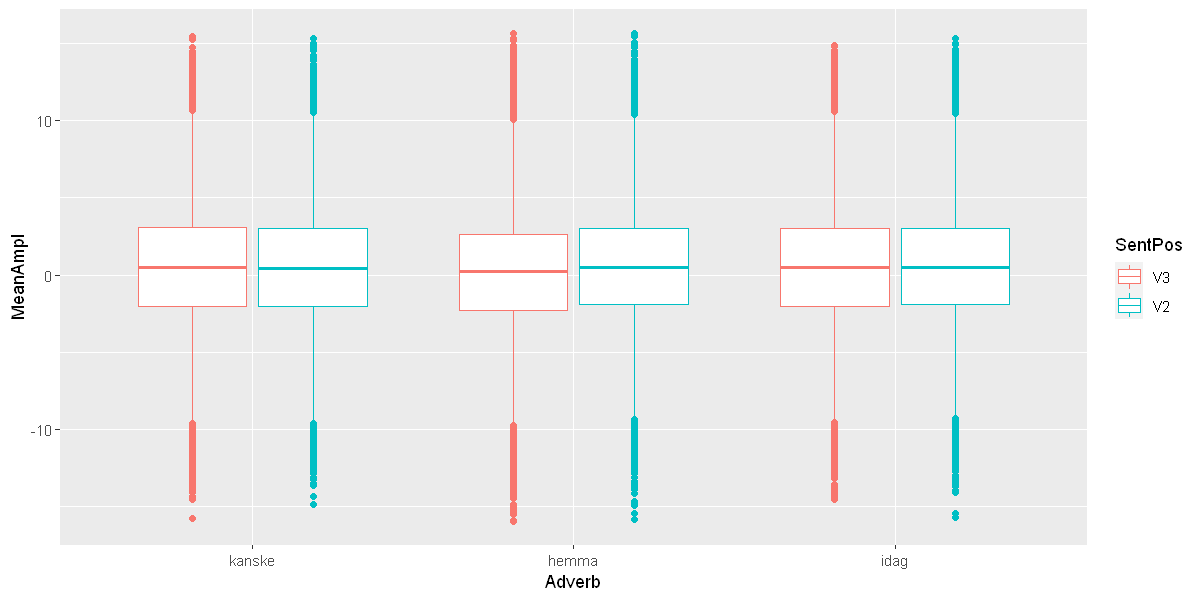

In [10]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(dat, aes(y=MeanAmpl, x=Adverb, col=SentPos)) + 
    geom_boxplot() 

## LME modelling

Note: we use the `bam()` function but fit linear models.

### Fit a simple-but-full model without baseline

In [11]:
cl <- makeCluster(num_cores)  

m0 <- bam(MeanAmpl ~ (Adverb * SentPos * ROI)
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)


Method: fREML   Optimizer: perf newton
full convergence after 8 iterations.
Gradient range [-0.000000055952,-0.00000000000012434]
(score 352898 & scale 15.822).
Hessian positive definite, eigenvalue range [9.2207,62982].
Model rank =  74 / 74 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

             k'  edf k-index p-value
s(Subject) 20.0 18.7      NA      NA


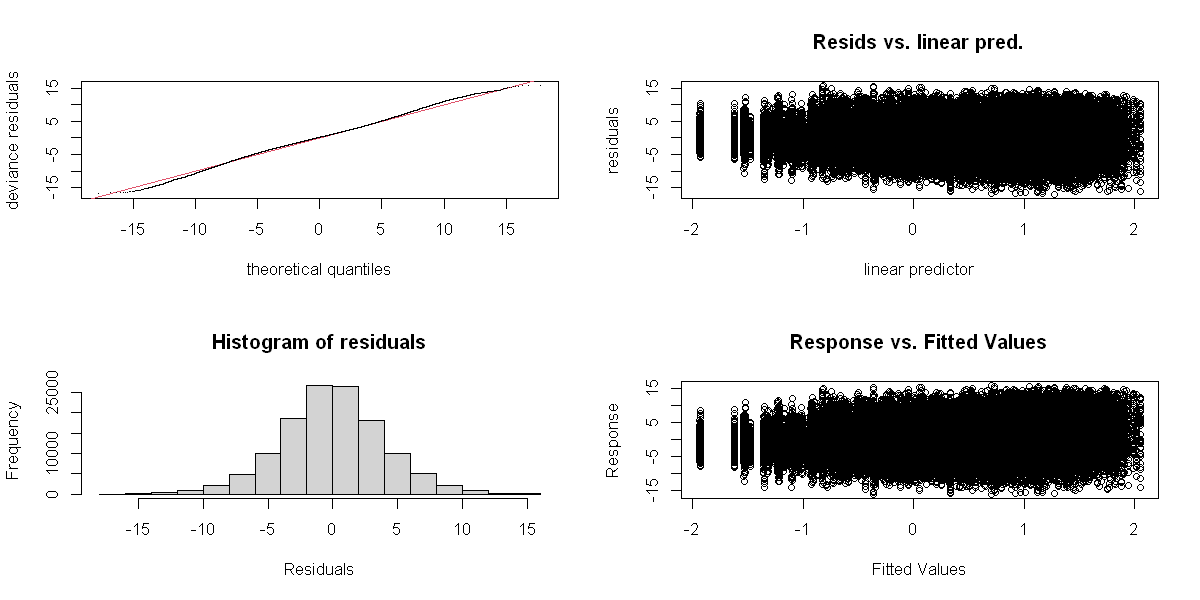

In [12]:
gam.check(m0)

In [13]:
anova(m0)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb * SentPos * ROI) + s(Subject, bs = "re")

Parametric Terms:
                   df     F             p-value
Adverb              2  1.04               0.355
SentPos             1  0.36               0.548
ROI                 8 77.98 <0.0000000000000002
Adverb:SentPos      2  0.36               0.701
Adverb:ROI         16  2.14               0.005
SentPos:ROI         8  2.23               0.022
Adverb:SentPos:ROI 16  1.67               0.044

Approximate significance of smooth terms:
            edf Ref.df    F             p-value
s(Subject) 18.7   19.0 66.9 <0.0000000000000002

## Include baseline as fixed effect, not interacting with other factors

In [14]:
cl <- makeCluster(num_cores)  

m_b_nox <- bam(MeanAmpl ~ (Adverb * SentPos * ROI) + baseline
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Include baseline as a fixed effect, *fully interacting* with other factors

In [15]:
cl <- makeCluster(num_cores)  

m_full <- bam(MeanAmpl ~ (Adverb * SentPos * ROI * baseline)
          + s(Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Add random intercepts for items (sentences) as well as subjects

In [11]:
cl <- makeCluster(num_cores)  

mf_4w_rei <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Allow only 3-way interactions

In [17]:
cl <- makeCluster(num_cores)  

mf_3w_rei <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^3
          + s(Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Random slopes for items (sentences) within subjects, and random slopes for Channel within subjects, 4 way interactions

This takes a long time to fit, and requires lots of RAM

In [18]:
cl <- makeCluster(num_cores)  

mf_4w_recsis <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Channel, Subject, bs='re') + s(Sentence, Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

### Random slopes for items (sentences) within subjects, and random slopes for Channel within subjects, 3 way interactions

In [19]:
cl <- makeCluster(num_cores)  

mf_3w_recsis <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^3
          + s(Channel, Subject, bs='re') + s(Sentence, Subject, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

## Random intercepts by item, not nested in subjects

In [20]:
cl <- makeCluster(num_cores)  

mf_4w_reci <- bam(MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4
          + s(Channel, Subject, bs='re') + s(Sentence, bs='re'),
          data=dat,
          samfrac=.1, cluster=cl, gc.level=2
         )
stopCluster(cl)

## Compare models

In [21]:
AICtab <- as.data.frame(AIC(m0, m_full, m_b_nox, 
                            mf_3w_rei, mf_3w_recsis,
                            mf_4w_rei, mf_4w_recsis, mf_4w_reci
                           )) 
AICtab$deltaAIC <-AICtab$AIC - min(AICtab$AIC)
AICtab[order(AICtab$AIC),]

,df,AIC,deltaAIC
,<dbl>,<dbl>,<dbl>
mf_4w_recsis,5219.114,616354,0.000
mf_3w_recsis,5203.059,616378,23.979
mf_4w_reci,815.052,698483,82129.199
mf_3w_rei,333.083,701774,85420.105
mf_4w_rei,349.089,701779,85425.245
m_full,127.785,704839,88485.169
m_b_nox,74.784,704885,88531.302
m0,73.750,705685,89331.166


---
## Explore best model

### Best Model

**`mf_4w_recsis`** has smallest AIC

However, the random effects structure is so complex that we can't generate plots of this model below (requires more RAM than we have; takes > 24 h to fit and then maybe crashes). For those we use the model **`mf_4w_reci`**, which is the same but with only random intercepts by sentence, not sentence-by-subject RE

The plotted effect sizes and confidence intervals do not change in any visually-detectable way between these models with different random effects structures anyway.

In [22]:
anova(mf_4w_recsis)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Channel, 
    Subject, bs = "re") + s(Sentence, Subject, bs = "re")

Parametric Terms:
                            df      F              p-value
Adverb                       2   0.32               0.7275
SentPos                      1   0.20               0.6531
ROI                          8  47.47 < 0.0000000000000002
baseline                     1 122.96 < 0.0000000000000002
Adverb:SentPos               2   0.55               0.5795
Adverb:ROI                  16   4.66         0.0000000016
Adverb:baseline              2   0.40               0.6713
SentPos:ROI                  8   4.77         0.0000069636
SentPos:baseline             1   4.41               0.0357
ROI:baseline                 8   4.02         0.0000885500
Adverb:SentPos:ROI          16   2.40               0.0013
Adverb:SentPos:baseline      2   0.22               0.8004
Adverb:ROI:baseline         16   2.13  

### Write ANOVA table to text file

In [23]:
summary(mf_4w_recsis)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Channel, 
    Subject, bs = "re") + s(Sentence, Subject, bs = "re")

Parametric coefficients:
                                         Estimate Std. Error t value
(Intercept)                               1.24814    0.13950    8.95
Adverbhemma                              -0.12294    0.15830   -0.78
Adverbidag                               -0.08623    0.15796   -0.55
SentPosV2                                -0.07117    0.15837   -0.45
ROIM_Ant                                  0.12263    0.21848    0.56
ROIR_Ant                                  0.13665    0.13769    0.99
ROIL_Cent                                -0.46433    0.13707   -3.39
ROIM_Cent                                 0.33594    0.21971    1.53
ROIR_Cent                                -0.42500    0.13749   -3.09
ROIL_Post                                -1.92975    0.13714  -14.07
ROIM_Post                               

### View the model that gives best AIC, within computational feasibility

In [12]:
mod = mf_4w_rei #mf_4w_rei

In [13]:
capture.output(anova(mod), file=paste(out_path, 'anova_table_', component, '.txt', sep=""))

In [14]:
anova(mod)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Subject, 
    bs = "re") + s(Sentence, bs = "re")

Parametric Terms:
                            df     F              p-value
Adverb                       2  0.39              0.67484
SentPos                      1  0.82              0.36421
ROI                          8 84.67 < 0.0000000000000002
baseline                     1 51.34     0.00000000000078
Adverb:SentPos               2  1.16              0.31210
Adverb:ROI                  16  2.47              0.00092
Adverb:baseline              2  0.21              0.80951
SentPos:ROI                  8  2.50              0.01030
SentPos:baseline             1  4.89              0.02705
ROI:baseline                 8  3.04              0.00201
Adverb:SentPos:ROI          16  1.70              0.03875
Adverb:SentPos:baseline      2  0.30              0.73977
Adverb:ROI:baseline         16  1.86              0.01935
SentPos:ROI:

In [26]:
summary(mod)


Family: gaussian 
Link function: identity 

Formula:
MeanAmpl ~ (Adverb + SentPos + ROI + baseline)^4 + s(Subject, 
    bs = "re") + s(Sentence, bs = "re")

Parametric coefficients:
                                          Estimate Std. Error t value
(Intercept)                               1.188123   0.141037    8.42
Adverbhemma                              -0.125836   0.142884   -0.88
Adverbidag                               -0.075484   0.142271   -0.53
SentPosV2                                -0.091994   0.101384   -0.91
ROIM_Ant                                  0.109955   0.162446    0.68
ROIR_Ant                                  0.169930   0.101369    1.68
ROIL_Cent                                -0.426001   0.099644   -4.28
ROIM_Cent                                 0.327187   0.165641    1.98
ROIR_Cent                                -0.392469   0.100748   -3.90
ROIL_Post                                -1.860883   0.099731  -18.66
ROIM_Post                                -0.220

## View results

In [27]:
contr <- emmeans(mod,  pairwise ~ SentPos | Adverb * ROI)

contr_tab = contr$contrasts %>% as.data.frame()
ncomp = nrow(contr_tab)
contr_tab$'p (raw)'   = round(contr_tab$'p.value', 4)
contr_tab$'p (FDR BH)' = round(p.adjust(contr_tab$'p.value', method = 'BH', n = ncomp), 4)
contr_tab <- subset(contr_tab, select=-c(p.value))
contr_tab

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



,contrast,Adverb,ROI,estimate,SE,df,t.ratio,p (raw),p (FDR BH)
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,V3 - V2,kanske,L_Ant,0.0411662,0.099645,125670,0.413127,0.6795,0.8000
2,V3 - V2,hemma,L_Ant,0.0899358,0.099314,125670,0.905569,0.3652,0.5800
3,V3 - V2,idag,L_Ant,-0.1000781,0.099853,125670,-1.002253,0.3162,0.5336
4,V3 - V2,kanske,M_Ant,-0.0170716,0.204616,125670,-0.083433,0.9335,0.9694
5,V3 - V2,hemma,M_Ant,-0.3847401,0.204196,125670,-1.884167,0.0595,0.1608
6,V3 - V2,idag,M_Ant,-0.4102290,0.205411,125670,-1.997112,0.0458,0.1374
7,V3 - V2,kanske,R_Ant,0.2110058,0.099613,125670,2.118266,0.0342,0.1153
8,V3 - V2,hemma,R_Ant,-0.0445053,0.099530,125670,-0.447155,0.6548,0.8000
9,V3 - V2,idag,R_Ant,-0.0258839,0.100008,125670,-0.258820,0.7958,0.8594


## Get effect sizes on differences 
Cohen's *d*

### Plot effect sizes for all V3-V2 contrasts

Also save a PDF version of the plot

Since 'object' is a list, we are using the contrasts already present.



png 
  2

Since 'object' is a list, we are using the contrasts already present.



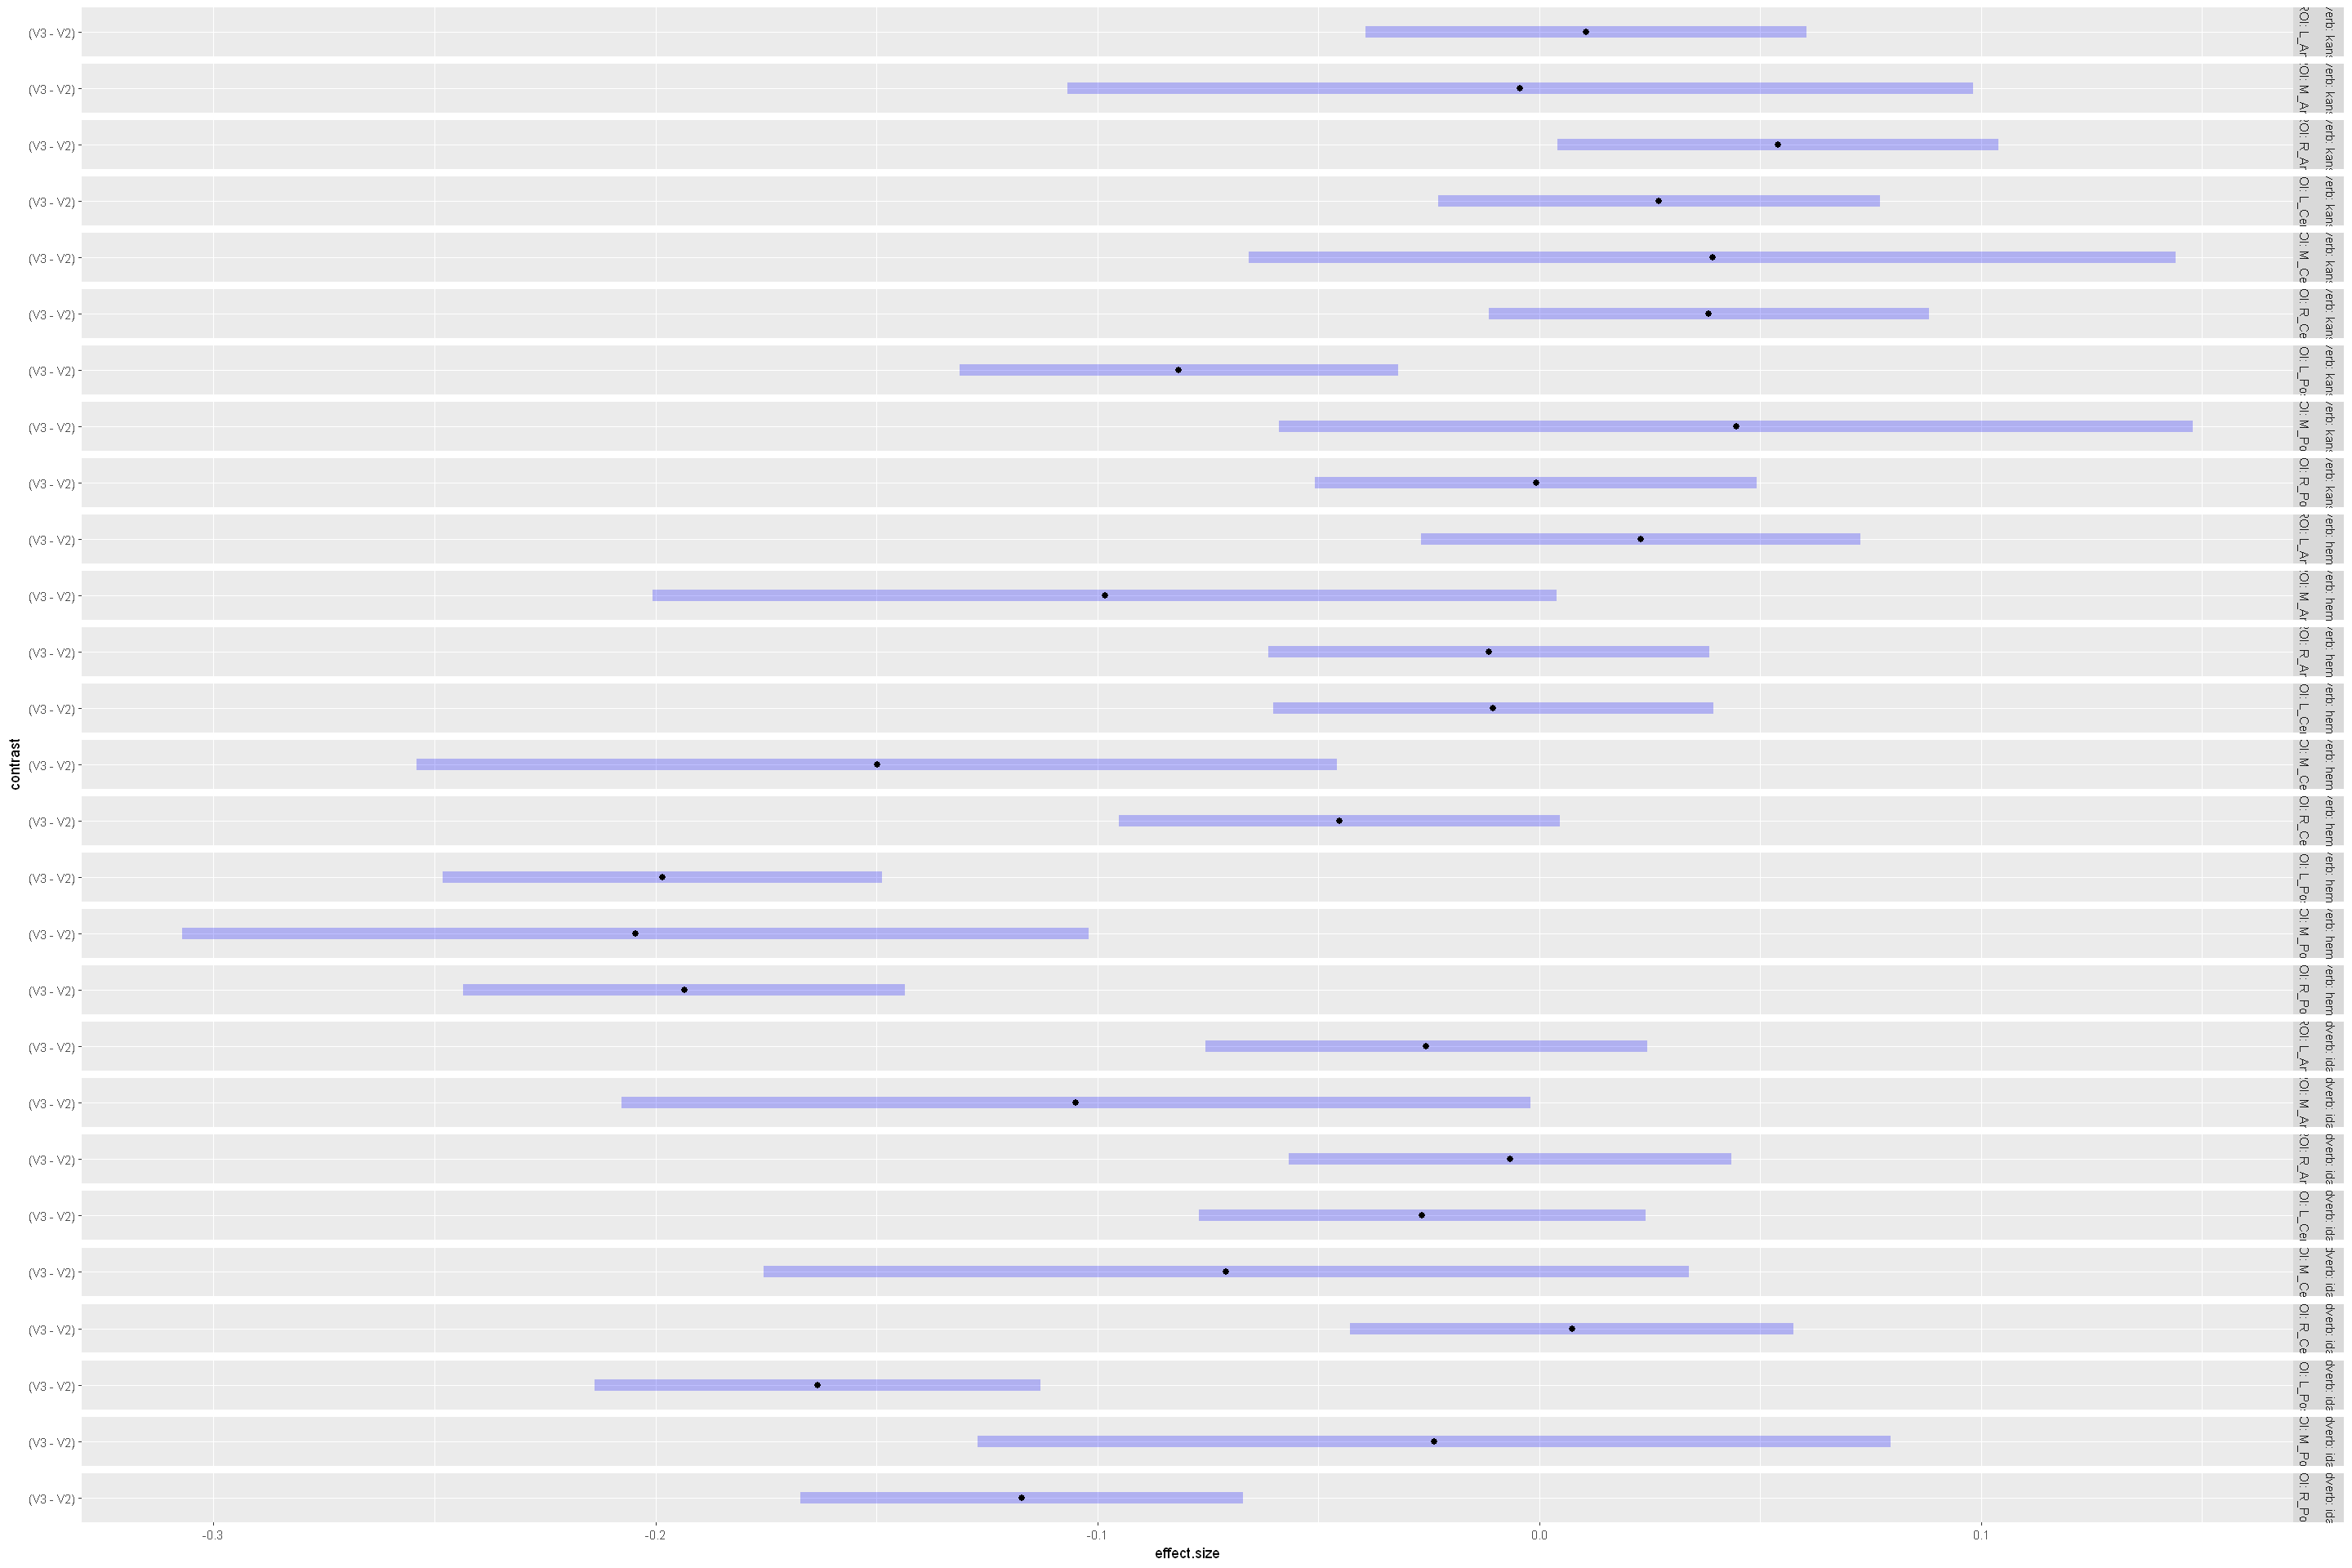

In [28]:
pdf(paste(out_path, 'figures/R plots/', 'lme_effect_plot_', component, '.pdf', sep="")) 
plot(eff_size(contr, sigma = sigma(mod), edf = 125000))
dev.off() 
options(repr.plot.width=24, repr.plot.height=16)
plot(eff_size(contr, sigma = sigma(mod), edf = 125000))

In [29]:
eff_tab <- eff_size(contr, sigma = sigma(mod), edf = 125000) %>% as.data.frame()
full_tab <- contr_tab %>% full_join(eff_tab, by=c("ROI", 'Adverb'), suffix = c(".ctr", ".eff"))
full_tab

Since 'object' is a list, we are using the contrasts already present.



contrast.ctr,Adverb,ROI,estimate,SE.ctr,df.ctr,t.ratio,p (raw),p (FDR BH),contrast.eff,effect.size,SE.eff,df.eff,lower.CL,upper.CL
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
V3 - V2,kanske,L_Ant,0.0411662,0.099645,125670,0.413127,0.6795,0.8000,(V3 - V2),0.01052154,0.025468,125670,-0.0393954,0.0604385
V3 - V2,hemma,L_Ant,0.0899358,0.099314,125670,0.905569,0.3652,0.5800,(V3 - V2),0.02298642,0.025383,125670,-0.0267647,0.0727375
V3 - V2,idag,L_Ant,-0.1000781,0.099853,125670,-1.002253,0.3162,0.5336,(V3 - V2),-0.02557868,0.025521,125670,-0.0755998,0.0244425
V3 - V2,kanske,M_Ant,-0.0170716,0.204616,125670,-0.083433,0.9335,0.9694,(V3 - V2),-0.00436329,0.052297,125670,-0.1068647,0.0981381
V3 - V2,hemma,M_Ant,-0.3847401,0.204196,125670,-1.884167,0.0595,0.1608,(V3 - V2),-0.09833459,0.052190,125670,-0.2006268,0.0039576
V3 - V2,idag,M_Ant,-0.4102290,0.205411,125670,-1.997112,0.0458,0.1374,(V3 - V2),-0.10484922,0.052501,125670,-0.2077500,-0.0019485
V3 - V2,kanske,R_Ant,0.2110058,0.099613,125670,2.118266,0.0342,0.1153,(V3 - V2),0.05393035,0.025460,125670,0.0040294,0.1038313
V3 - V2,hemma,R_Ant,-0.0445053,0.099530,125670,-0.447155,0.6548,0.8000,(V3 - V2),-0.01137497,0.025439,125670,-0.0612340,0.0384841
V3 - V2,idag,R_Ant,-0.0258839,0.100008,125670,-0.258820,0.7958,0.8594,(V3 - V2),-0.00661560,0.025561,125670,-0.0567140,0.0434828


### Write above table to file

In [30]:
write.csv(full_tab, file=paste(out_path, 'contrast_table_', component, '.csv' ,sep=''))

## Plot Model

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



png 
  2

NOTE: A nesting structure was detected in the fitted model:
    Sentence %in% Adverb

NOTE: Results may be misleading due to involvement in interactions



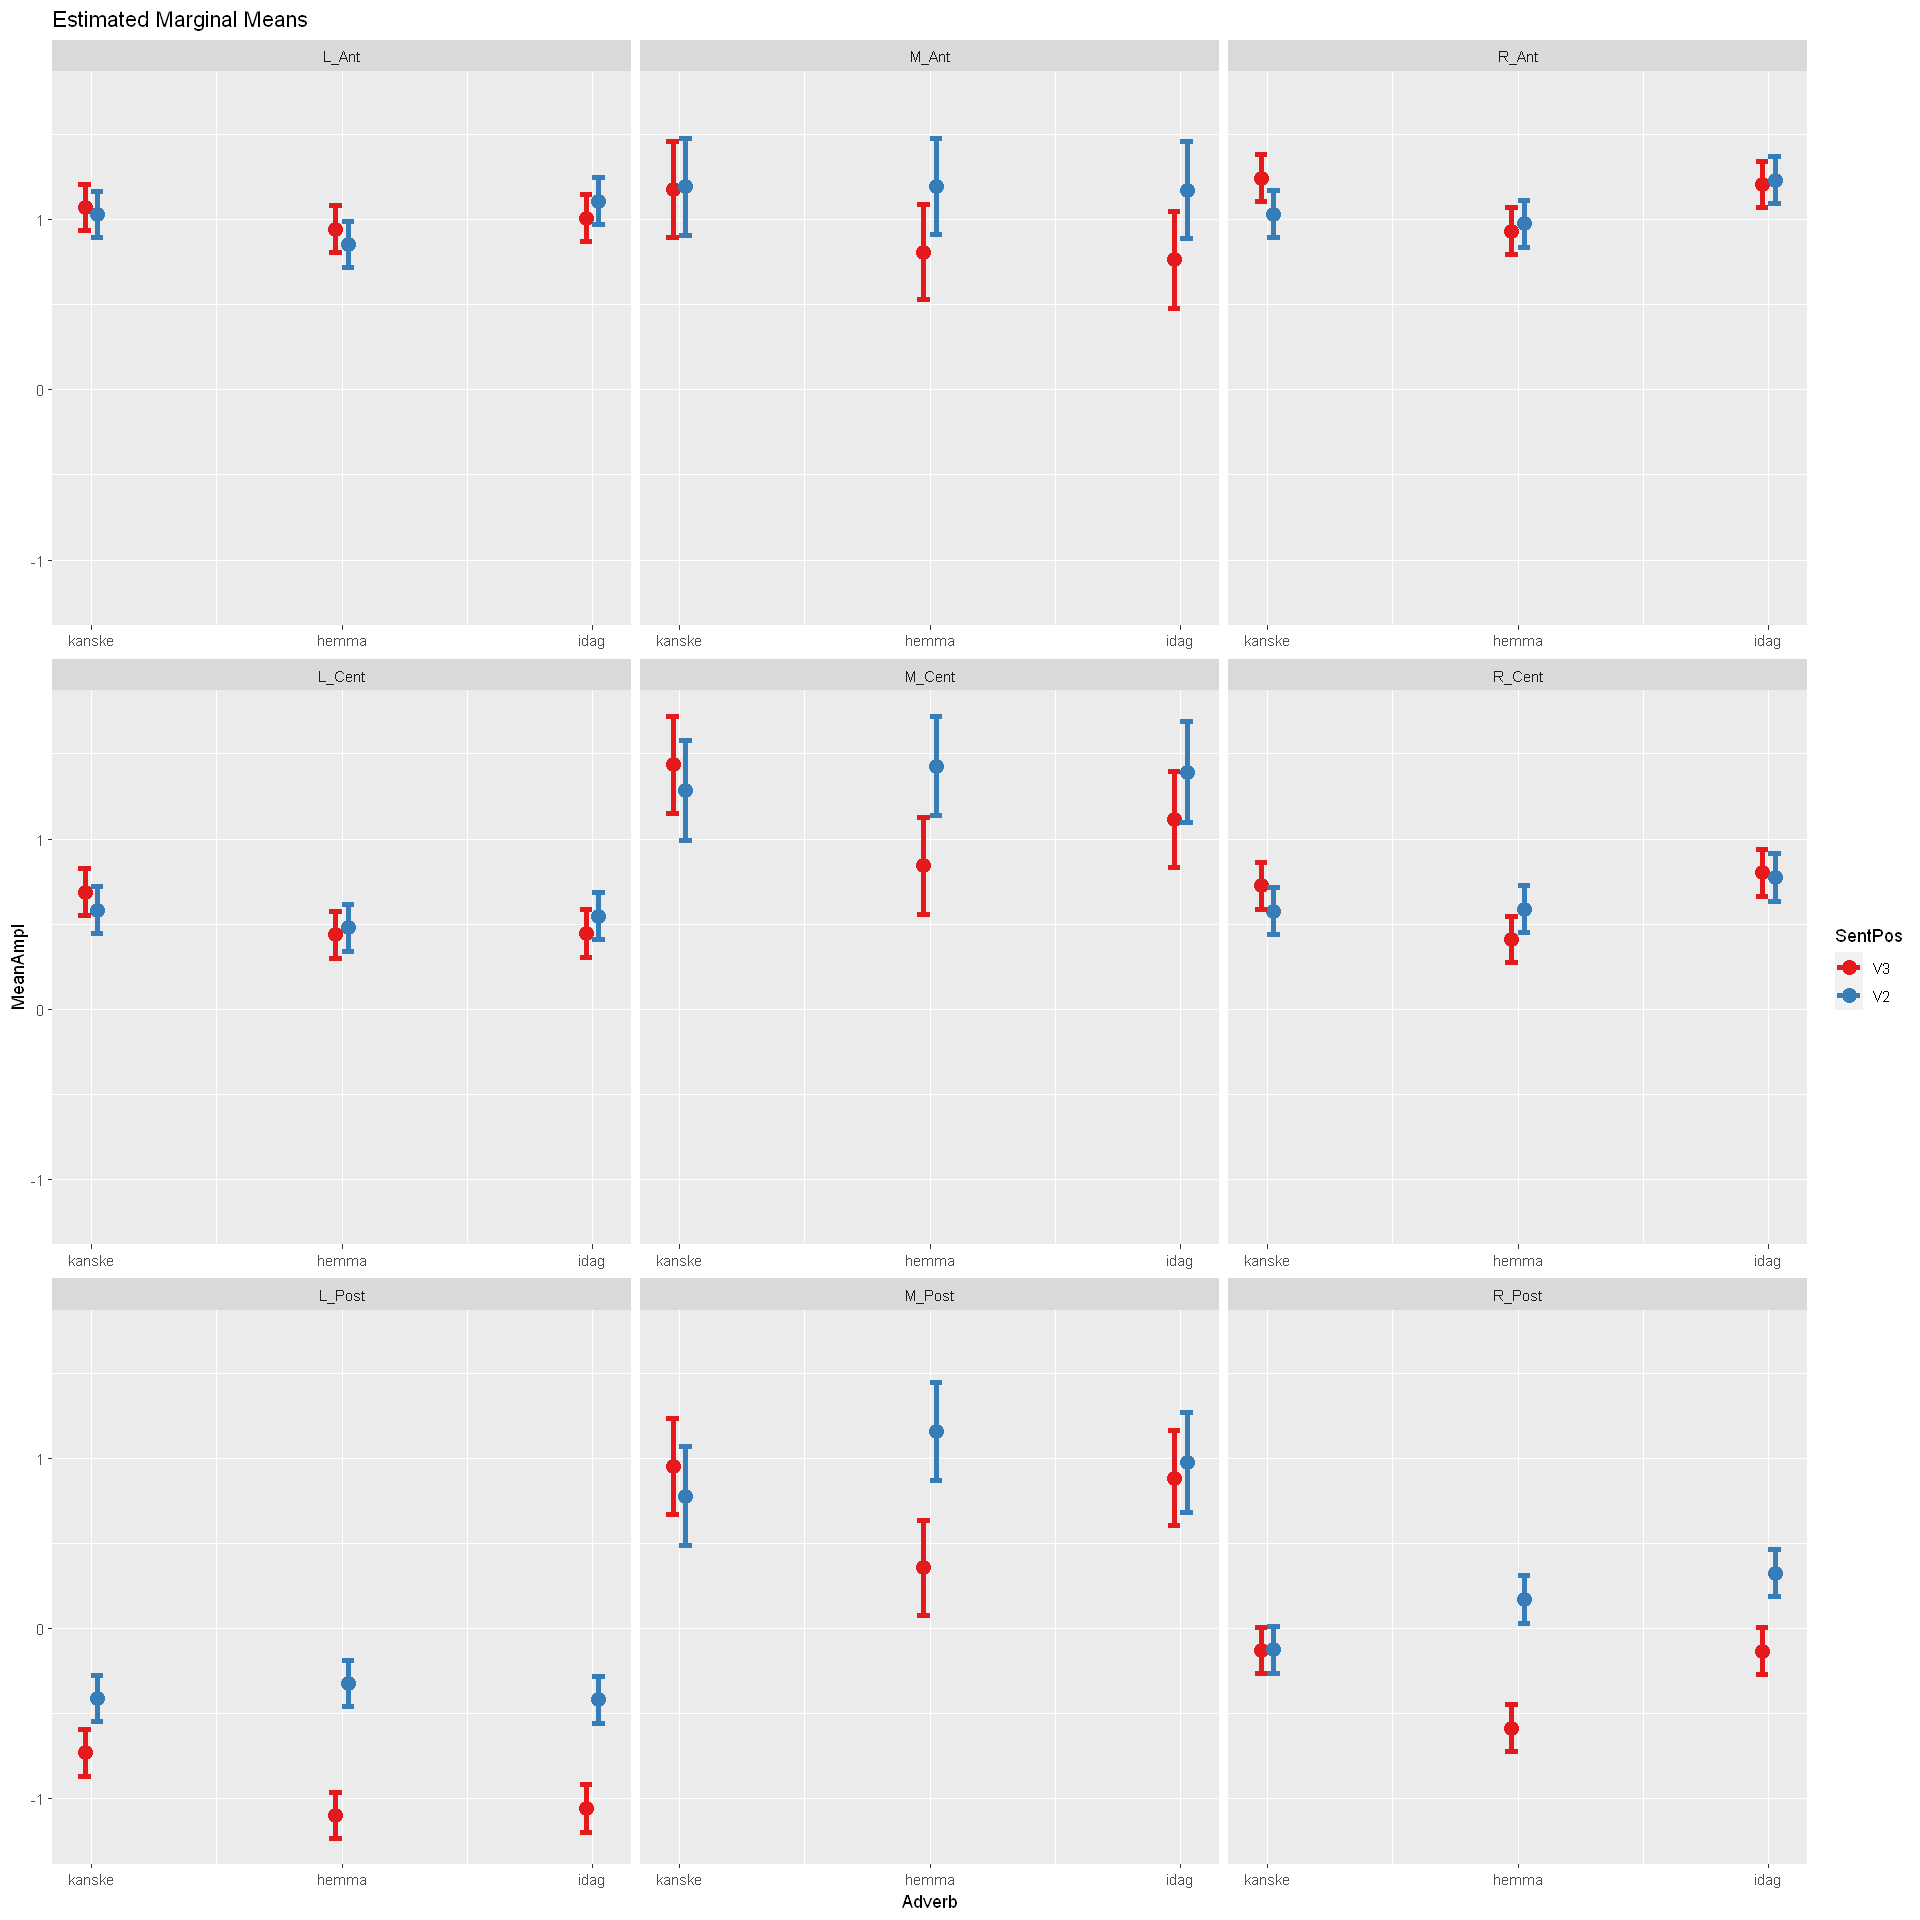

In [31]:
# save PDF
pdf(paste(out_path, 'figures/R plots/', 'lme_model_plot_', component, '.pdf', sep="")) 
plot_model(mod, 
           type='emm',
           terms=c('Adverb', 'SentPos', 'ROI'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )
dev.off() 

# plot in this notebook
options(repr.plot.width=16, repr.plot.height=16)
plot_model(mod, 
           type='emm',
           terms=c('Adverb', 'SentPos', 'ROI'),
           dot.size=4, line.size=1.5,  panel.minor.gridcol = 1,
           title='Estimated Marginal Means'
          )

In [32]:
date()

[1] "Sat Aug 28 22:55:08 2021"